Epoch [100/1000], Loss: 0.7784
Epoch [200/1000], Loss: 0.6211
Epoch [300/1000], Loss: 0.3311
Epoch [400/1000], Loss: 0.4099
Epoch [500/1000], Loss: 0.4542
Epoch [600/1000], Loss: 0.4717
Epoch [700/1000], Loss: 0.1856
Epoch [800/1000], Loss: 0.3544
Epoch [900/1000], Loss: 0.3379
Epoch [1000/1000], Loss: 0.1594


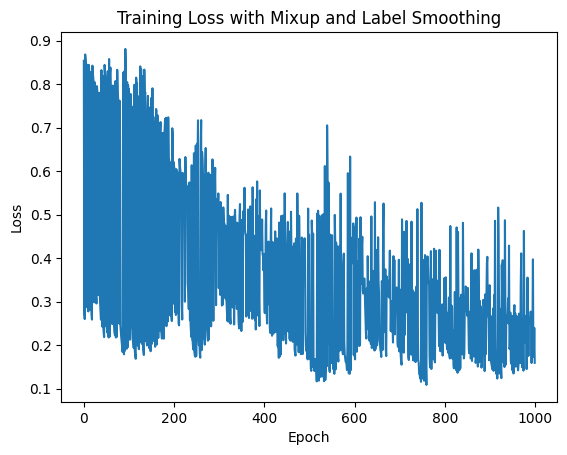

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# สร้างข้อมูลจำลอง
np.random.seed(42)
torch.manual_seed(42)

# ข้อมูลจำลอง
x_data = torch.Tensor([[0.7], [0.4], [0.9]])
y_data = torch.Tensor([[0, 1], [1, 0], [0, 1]])

# สร้างโมเดลแบบง่าย
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(1, 2)
    
    def forward(self, x):
        return self.fc(x)

# ฟังก์ชัน Loss
def mixup(x1, x2, y1, y2, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    x_mix = lam * x1 + (1 - lam) * x2
    y_mix = lam * y1 + (1 - lam) * y2
    return x_mix, y_mix

def label_smoothing(y, epsilon=0.1):
    K = y.size(1)
    return (1 - epsilon) * y + epsilon / K

def loss_corrected(y_true, y_pred, C):
    loss_fn = nn.CrossEntropyLoss(reduction='none')
    losses = loss_fn(y_pred, y_true.argmax(dim=1))
    corrected_losses = C * losses
    return corrected_losses.mean()

# สร้างโมเดล
model = SimpleModel()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# เทรนโมเดลและเก็บค่า loss
epochs = 1000
losses = []

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Mixup
    x_mix, y_mix = mixup(x_data[0], x_data[1], y_data[0], y_data[1])
    x_mix = torch.cat((x_mix.unsqueeze(0), x_data[2].unsqueeze(0)))
    y_mix = torch.cat((y_mix.unsqueeze(0), y_data[2].unsqueeze(0)))
    
    # Forward pass
    outputs = model(x_mix)
    
    # Label Smoothing
    y_smooth = label_smoothing(y_mix)
    
    # Compute loss (CrossEntropy with Label Smoothing)
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(outputs, y_smooth.argmax(dim=1))
    
    # Backward and optimize
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    # Print loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plotting loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss with Mixup and Label Smoothing')
plt.show()


In [5]:
!pip install ace

   Epoch  Focal Loss  Generalized Cross-Entropy Loss  Hinge Loss  Huber Loss  \
0      1    0.072861                        0.444112    1.473676    0.373443   
1      2    0.071913                        0.443460    1.448676    0.339438   
2      3    0.070988                        0.442827    1.423676    0.308573   
3      4    0.070084                        0.442214    1.398676    0.281236   
4      5    0.069202                        0.441619    1.373676    0.257217   

   Smooth L1 Loss  
0        0.188226  
1        0.182424  
2        0.177344  
3        0.172889  
4        0.168976  


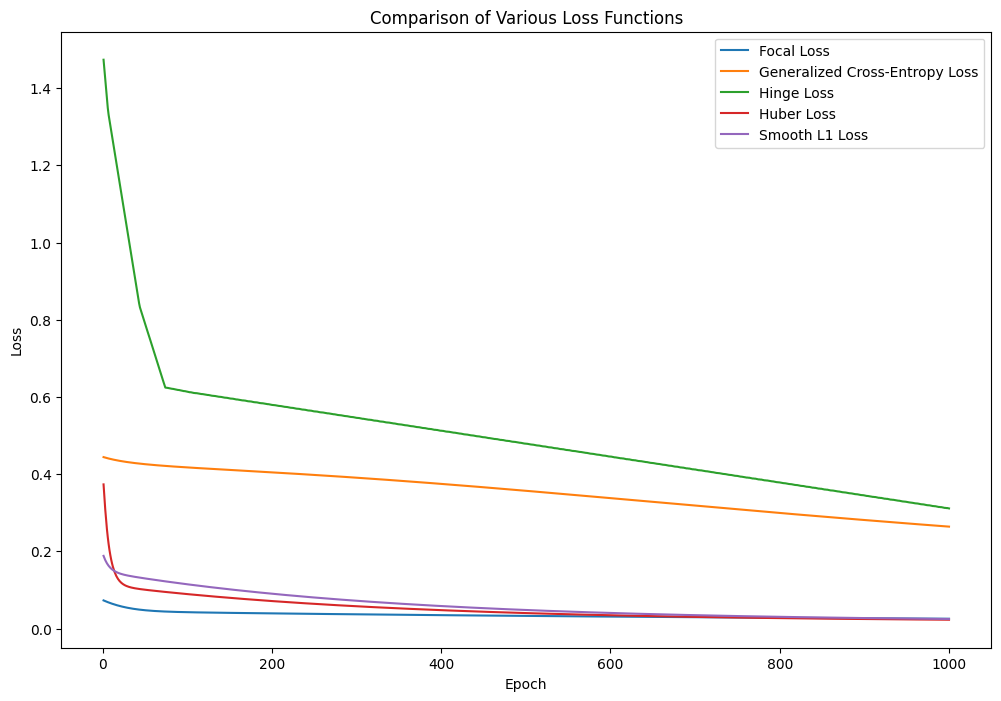

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# สร้างข้อมูลจำลอง
np.random.seed(42)
torch.manual_seed(42)

x_data = torch.Tensor([[0.7], [0.4], [0.9]])
y_data = torch.Tensor([[0, 1], [1, 0], [0, 1]])

# สร้างโมเดลแบบง่าย
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(1, 2)
    
    def forward(self, x):
        return self.fc(x)

# ฟังก์ชัน loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
    
    def forward(self, y_true, y_pred):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(y_pred, y_true.argmax(dim=1))
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

class GeneralizedCrossEntropyLoss(nn.Module):
    def __init__(self, q=0.7):
        super(GeneralizedCrossEntropyLoss, self).__init__()
        self.q = q
    
    def forward(self, y_true, y_pred):
        p = torch.softmax(y_pred, dim=1)
        gce_loss = (1 - torch.sum(y_true * p, dim=1) ** self.q) / self.q
        return gce_loss.mean()

class HingeLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(HingeLoss, self).__init__()
        self.margin = margin
    
    def forward(self, y_true, y_pred):
        loss = torch.max(torch.zeros_like(y_pred), self.margin - y_pred * (2 * y_true - 1))
        return loss.mean()

class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(HuberLoss, self).__init__()
        self.delta = delta
    
    def forward(self, y_true, y_pred):
        residual = torch.abs(y_true - y_pred)
        loss = torch.where(residual < self.delta, 0.5 * residual ** 2, self.delta * (residual - 0.5 * self.delta))
        return loss.mean()

class SmoothL1Loss(nn.Module):
    def __init__(self):
        super(SmoothL1Loss, self).__init__()
    
    def forward(self, y_true, y_pred):
        residual = torch.abs(y_true - y_pred)
        loss = torch.where(residual < 1, 0.5 * residual ** 2, residual - 0.5)
        return loss.mean()

class CategoricalHingeLoss(nn.Module):
    def __init__(self):
        super(CategoricalHingeLoss, self).__init__()
    
    def forward(self, y_true, y_pred):
        max_false = torch.max((1 - y_true) * y_pred, dim=1)[0]
        loss = torch.max(torch.zeros_like(y_pred), y_pred[y_true.bool()] - max_false + 1)
        return loss.mean()

# ฟังก์ชันเทรนโมเดล
def train_model(model, optimizer, loss_fn, x_data, y_data, epochs=1000):
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        outputs = model(x_data)
        loss = loss_fn(y_data, outputs)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    return losses

# สร้างโมเดลและ optimizer สำหรับแต่ละ Loss Function
model_focal = SimpleModel()
optimizer_focal = optim.SGD(model_focal.parameters(), lr=0.1)

model_gce = SimpleModel()
optimizer_gce = optim.SGD(model_gce.parameters(), lr=0.1)

model_hinge = SimpleModel()
optimizer_hinge = optim.SGD(model_hinge.parameters(), lr=0.1)

model_huber = SimpleModel()
optimizer_huber = optim.SGD(model_huber.parameters(), lr=0.1)

model_smoothl1 = SimpleModel()
optimizer_smoothl1 = optim.SGD(model_smoothl1.parameters(), lr=0.1)

# เทรนและเก็บ loss ของแต่ละโมเดล
losses_focal = train_model(model_focal, optimizer_focal, FocalLoss(), x_data, y_data)
losses_gce = train_model(model_gce, optimizer_gce, GeneralizedCrossEntropyLoss(), x_data, y_data)
losses_hinge = train_model(model_hinge, optimizer_hinge, HingeLoss(), x_data, y_data)
losses_huber = train_model(model_huber, optimizer_huber, HuberLoss(), x_data, y_data)
losses_smoothl1 = train_model(model_smoothl1, optimizer_smoothl1, SmoothL1Loss(), x_data, y_data)

# สร้าง DataFrame สำหรับเก็บค่าการลดลงของ loss ทั้งหมด
losses_df = pd.DataFrame({
    'Epoch': list(range(1, 1001)),
    'Focal Loss': losses_focal,
    'Generalized Cross-Entropy Loss': losses_gce,
    'Hinge Loss': losses_hinge,
    'Huber Loss': losses_huber,
    'Smooth L1 Loss': losses_smoothl1
})

# แสดงผลลัพธ์ของ loss ทั้งหมดในรูปแบบตาราง
print(losses_df.head())

# Plotting loss
plt.figure(figsize=(12, 8))
plt.plot(losses_df['Epoch'], losses_df['Focal Loss'], label='Focal Loss')
plt.plot(losses_df['Epoch'], losses_df['Generalized Cross-Entropy Loss'], label='Generalized Cross-Entropy Loss')
plt.plot(losses_df['Epoch'], losses_df['Hinge Loss'], label='Hinge Loss')
plt.plot(losses_df['Epoch'], losses_df['Huber Loss'], label='Huber Loss')
plt.plot(losses_df['Epoch'], losses_df['Smooth L1 Loss'], label='Smooth L1 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of Various Loss Functions')
plt.legend()
plt.show()


   Epoch  Focal Loss  Generalized Cross-Entropy Loss  \
0      1    0.072861                        0.444112   
1      2    0.071913                        0.443460   
2      3    0.070988                        0.442827   
3      4    0.070084                        0.442214   
4      5    0.069202                        0.441619   

   Knowledge Distillation Loss  
0                     0.066499  
1                     0.065917  
2                     0.065338  
3                     0.064763  
4                     0.064193  


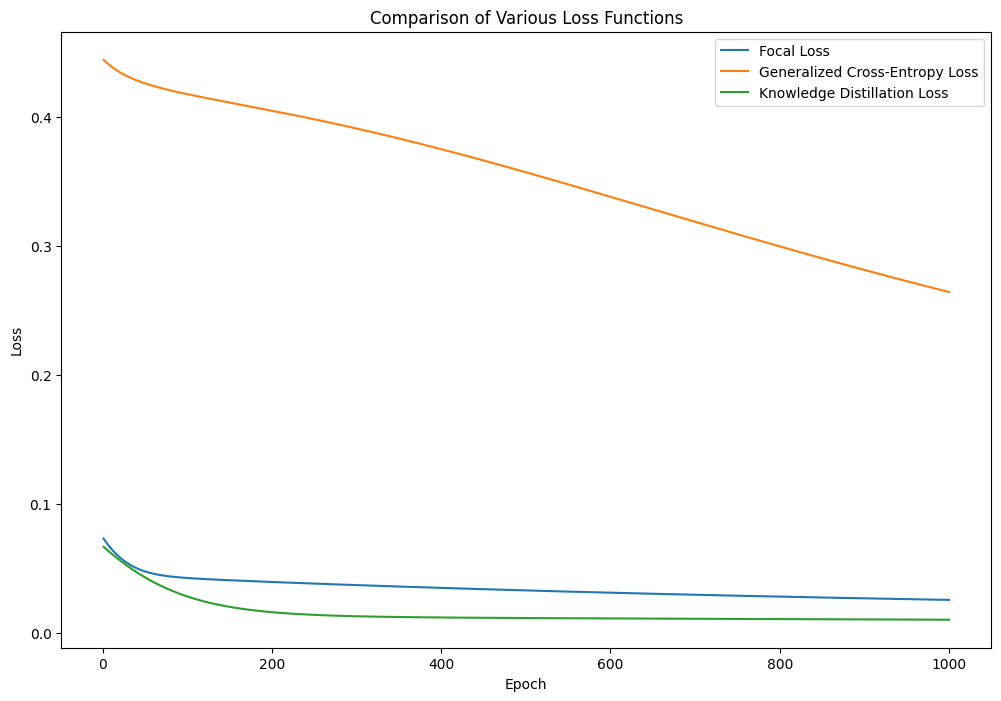

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# สร้างข้อมูลจำลอง
np.random.seed(42)
torch.manual_seed(42)

x_data = torch.Tensor([[0.7], [0.4], [0.9]])
y_data = torch.Tensor([[0, 1], [1, 0], [0, 1]])

# สร้างโมเดลแบบง่าย
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(1, 2)
    
    def forward(self, x):
        return self.fc(x)

# ฟังก์ชัน loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
    
    def forward(self, y_true, y_pred):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(y_pred, y_true.argmax(dim=1))
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

class GeneralizedCrossEntropyLoss(nn.Module):
    def __init__(self, q=0.7):
        super(GeneralizedCrossEntropyLoss, self).__init__()
        self.q = q
    
    def forward(self, y_true, y_pred):
        p = torch.softmax(y_pred, dim=1)
        gce_loss = (1 - torch.sum(y_true * p, dim=1) ** self.q) / self.q
        return gce_loss.mean()

class KnowledgeDistillationLoss(nn.Module):
    def __init__(self, alpha=0.1, temperature=1.0):
        super(KnowledgeDistillationLoss, self).__init__()
        self.alpha = alpha
        self.temperature = temperature
    
    def forward(self, y_pred_teacher, y_pred_student):
        kd_loss = nn.KLDivLoss(reduction='batchmean')(torch.log_softmax(y_pred_student / self.temperature, dim=1),
                                                       torch.softmax(y_pred_teacher / self.temperature, dim=1))
        kd_loss *= (self.temperature ** 2) * self.alpha
        return kd_loss.mean()

# ฟังก์ชันเทรนโมเดล
def train_model(model, optimizer, loss_fn, x_data, y_data, epochs=1000):
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        outputs = model(x_data)
        loss = loss_fn(y_data, outputs)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    return losses

# สร้างโมเดลและ optimizer สำหรับแต่ละ Loss Function
model_focal = SimpleModel()
optimizer_focal = optim.SGD(model_focal.parameters(), lr=0.1)

model_gce = SimpleModel()
optimizer_gce = optim.SGD(model_gce.parameters(), lr=0.1)

model_kd = SimpleModel()
optimizer_kd = optim.SGD(model_kd.parameters(), lr=0.1)

# เทรนและเก็บ loss ของแต่ละโมเดล
losses_focal = train_model(model_focal, optimizer_focal, FocalLoss(), x_data, y_data)
losses_gce = train_model(model_gce, optimizer_gce, GeneralizedCrossEntropyLoss(), x_data, y_data)
losses_kd = train_model(model_kd, optimizer_kd, KnowledgeDistillationLoss(), x_data, y_data)

# สร้าง DataFrame สำหรับเก็บค่าการลดลงของ loss ทั้งหมด
losses_df = pd.DataFrame({
    'Epoch': list(range(1, 1001)),
    'Focal Loss': losses_focal,
    'Generalized Cross-Entropy Loss': losses_gce,
    'Knowledge Distillation Loss': losses_kd
})

# แสดงผลลัพธ์ของ loss ทั้งหมดในรูปแบบตาราง
print(losses_df.head())

# Plotting loss
plt.figure(figsize=(12, 8))
plt.plot(losses_df['Epoch'], losses_df['Focal Loss'], label='Focal Loss')
plt.plot(losses_df['Epoch'], losses_df['Generalized Cross-Entropy Loss'], label='Generalized Cross-Entropy Loss')
plt.plot(losses_df['Epoch'], losses_df['Knowledge Distillation Loss'], label='Knowledge Distillation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of Various Loss Functions')
plt.legend()
plt.show()


   Epoch  Focal Loss  Generalized Cross-Entropy Loss  Huber Loss  \
0      1    0.343162                        1.260284    0.214679   
1      2    0.323849                             NaN    0.190337   
2      3    0.305223                             NaN    0.169612   
3      4    0.287323                             NaN    0.151967   
4      5    0.270182                             NaN    0.136942   

   Knowledge Distillation Loss  
0                     0.021690  
1                     0.021488  
2                     0.021287  
3                     0.021088  
4                     0.020890  


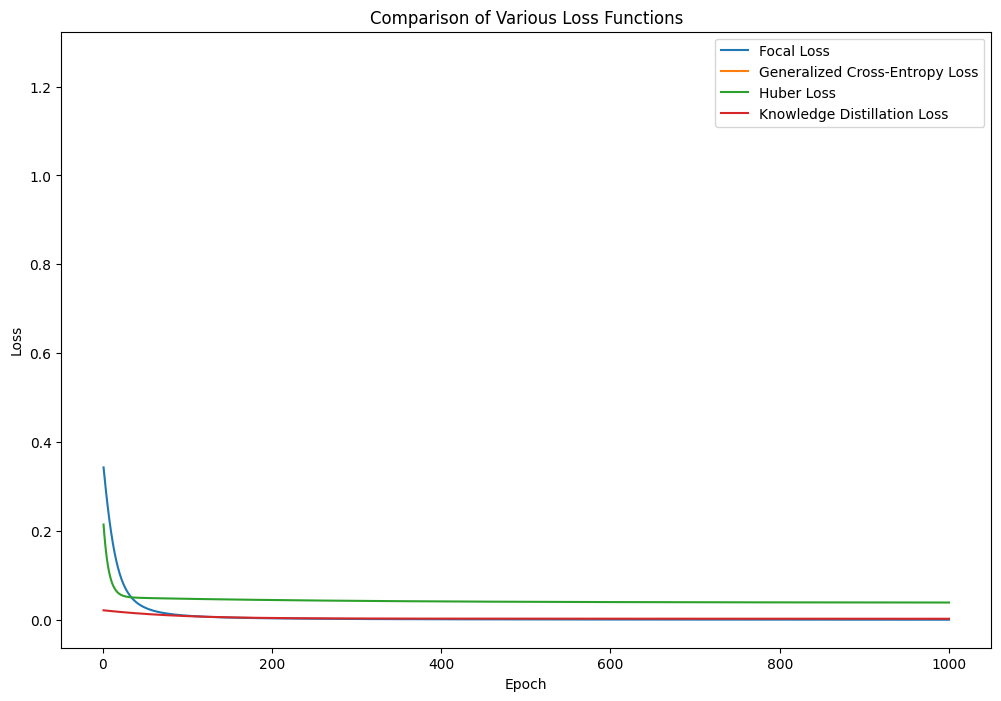

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# สร้างข้อมูลจำลอง
np.random.seed(42)
torch.manual_seed(42)

# สร้างชุดข้อมูล random สำหรับ x_data และ y_data
x_data = torch.rand((3, 1))  # สร้าง tensor ขนาด 3x1 ที่มีค่า random ในช่วง [0, 1)
y_data = torch.randint(0, 2, (3, 2))  # สร้าง tensor ขนาด 3x2 ที่มีค่า random เป็น 0 หรือ 1


# สร้างโมเดลแบบง่าย
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(1, 2)
    
    def forward(self, x):
        return self.fc(x)

# ฟังก์ชัน loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
    
    def forward(self, y_true, y_pred):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(y_pred, y_true.argmax(dim=1))
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

class GeneralizedCrossEntropyLoss(nn.Module):
    def __init__(self, q=0.7):
        super(GeneralizedCrossEntropyLoss, self).__init__()
        self.q = q
    
    def forward(self, y_true, y_pred):
        p = torch.softmax(y_pred, dim=1)
        gce_loss = (1 - torch.sum(y_true * p, dim=1) ** self.q) / self.q
        return gce_loss.mean()

class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(HuberLoss, self).__init__()
        self.delta = delta
    
    def forward(self, y_true, y_pred):
        criterion = nn.SmoothL1Loss(reduction='mean')
        return criterion(y_pred, y_true)

class KnowledgeDistillationLoss(nn.Module):
    def __init__(self, alpha=0.1, temperature=1.0):
        super(KnowledgeDistillationLoss, self).__init__()
        self.alpha = alpha
        self.temperature = temperature
    
    def forward(self, y_pred_teacher, y_pred_student):
        kd_loss = nn.KLDivLoss(reduction='batchmean')(torch.log_softmax(y_pred_student / self.temperature, dim=1),
                                                       torch.softmax(y_pred_teacher / self.temperature, dim=1))
        kd_loss *= (self.temperature ** 2) * self.alpha
        return kd_loss.mean()

# ฟังก์ชันเทรนโมเดล
def train_model(model, optimizer, loss_fn, x_data, y_data, epochs=1000):
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        outputs = model(x_data)
        loss = loss_fn(y_data, outputs)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    return losses

# สร้างโมเดลและ optimizer สำหรับแต่ละ Loss Function
model_focal = SimpleModel()
optimizer_focal = optim.SGD(model_focal.parameters(), lr=0.1)

model_gce = SimpleModel()
optimizer_gce = optim.SGD(model_gce.parameters(), lr=0.1)

model_huber = SimpleModel()
optimizer_huber = optim.SGD(model_huber.parameters(), lr=0.1)

model_kd = SimpleModel()
optimizer_kd = optim.SGD(model_kd.parameters(), lr=0.1)

# เทรนและเก็บ loss ของแต่ละโมเดล
losses_focal = train_model(model_focal, optimizer_focal, FocalLoss(), x_data, y_data)
losses_gce = train_model(model_gce, optimizer_gce, GeneralizedCrossEntropyLoss(), x_data, y_data)
losses_huber = train_model(model_huber, optimizer_huber, HuberLoss(), x_data, y_data)
losses_kd = train_model(model_kd, optimizer_kd, KnowledgeDistillationLoss(), x_data, y_data)

# สร้าง DataFrame สำหรับเก็บค่าการลดลงของ loss ทั้งหมด
losses_df = pd.DataFrame({
    'Epoch': list(range(1, 1001)),
    'Focal Loss': losses_focal,
    'Generalized Cross-Entropy Loss': losses_gce,
    'Huber Loss': losses_huber,
    'Knowledge Distillation Loss': losses_kd
})

# แสดงผลลัพธ์ของ loss ทั้งหมดในรูปแบบตาราง
print(losses_df.head())

# Plotting loss
plt.figure(figsize=(12, 8))
plt.plot(losses_df['Epoch'], losses_df['Focal Loss'], label='Focal Loss')
plt.plot(losses_df['Epoch'], losses_df['Generalized Cross-Entropy Loss'], label='Generalized Cross-Entropy Loss')
plt.plot(losses_df['Epoch'], losses_df['Huber Loss'], label='Huber Loss')
plt.plot(losses_df['Epoch'], losses_df['Knowledge Distillation Loss'], label='Knowledge Distillation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of Various Loss Functions')
plt.legend()
plt.show()


   Epoch  Combined Loss
0      1       0.143762
1      2       0.134900
2      3       0.126689
3      4       0.119085
4      5       0.112048


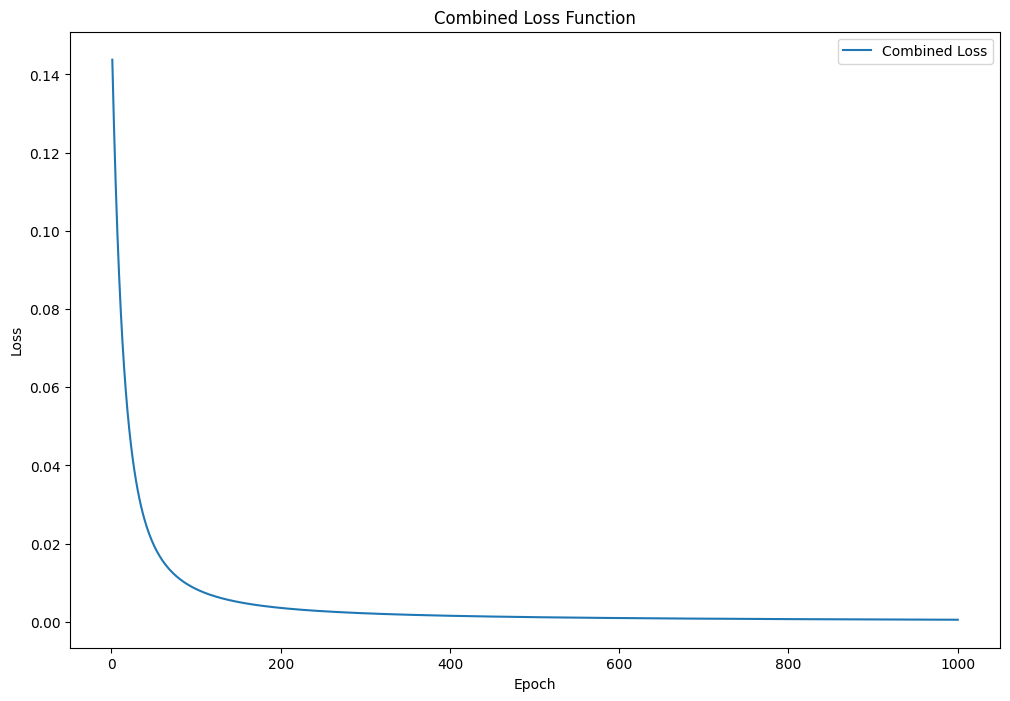

In [106]:

# สมการใหม่ที่รวม Focal Loss และ Knowledge Distillation Loss
class CombinedLoss(nn.Module):
    def __init__(self, focal_alpha=0.25, focal_gamma=2, kd_alpha=0.1, kd_temperature=1.0):
        super(CombinedLoss, self).__init__()
        self.focal_alpha = focal_alpha
        self.focal_gamma = focal_gamma
        self.kd_alpha = kd_alpha
        self.kd_temperature = kd_temperature
        self.focal_loss_fn = nn.CrossEntropyLoss(reduction='mean')
        self.kd_loss_fn = nn.KLDivLoss(reduction='batchmean')
    
    def forward(self, y_true, y_pred_teacher, y_pred_student):
        ce_loss = self.focal_loss_fn(y_pred_student, y_true.argmax(dim=1))
        pt = torch.exp(-ce_loss)
        focal_loss = self.focal_alpha * (1 - pt) ** self.focal_gamma * ce_loss
        
        kd_loss = self.kd_loss_fn(torch.log_softmax(y_pred_student / self.kd_temperature, dim=1),
                                  torch.softmax(y_pred_teacher / self.kd_temperature, dim=1))
        kd_loss *= (self.kd_temperature ** 2) * self.kd_alpha
        
        combined_loss = focal_loss + kd_loss
        return combined_loss

# ฟังก์ชันเทรนโมเดล
def train_model(model, optimizer, loss_fn, x_data, y_data, epochs=1000):
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        outputs = model(x_data)
        loss = loss_fn(y_data, outputs, outputs)  # ในที่นี้เรียกใช้ y_pred_teacher = y_pred_student
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    return losses

# สร้างโมเดลและ optimizer สำหรับ Combined Loss Function
model_combined = SimpleModel()
optimizer_combined = optim.SGD(model_combined.parameters(), lr=0.1)

# เทรนและเก็บ loss ของโมเดล
losses_combined = train_model(model_combined, optimizer_combined, CombinedLoss(), x_data, y_data)

# สร้าง DataFrame สำหรับเก็บค่าการลดลงของ loss ทั้งหมด
losses_df = pd.DataFrame({
    'Epoch': list(range(1, 1001)),
    'Combined Loss': losses_combined
})

# แสดงผลลัพธ์ของ loss ทั้งหมดในรูปแบบตาราง
print(losses_df.head())

# Plotting loss
plt.figure(figsize=(12, 8))
plt.plot(losses_df['Epoch'], losses_df['Combined Loss'], label='Combined Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Combined Loss Function')
plt.legend()
plt.show()


   Epoch  Focal Loss  Generalized Cross-Entropy Loss  Hinge Loss  Huber Loss  \
0      1    0.072861                        0.444112    1.473676    0.373443   
1      2    0.071913                        0.443460    1.448676    0.339438   
2      3    0.070988                        0.442827    1.423676    0.308573   
3      4    0.070084                        0.442214    1.398676    0.281236   
4      5    0.069202                        0.441619    1.373676    0.257217   

   Smooth L1 Loss  Knowledge Distillation Loss  
0        0.188226                     0.019468  
1        0.182424                     0.019361  
2        0.177344                     0.019256  
3        0.172889                     0.019151  
4        0.168976                     0.019048  


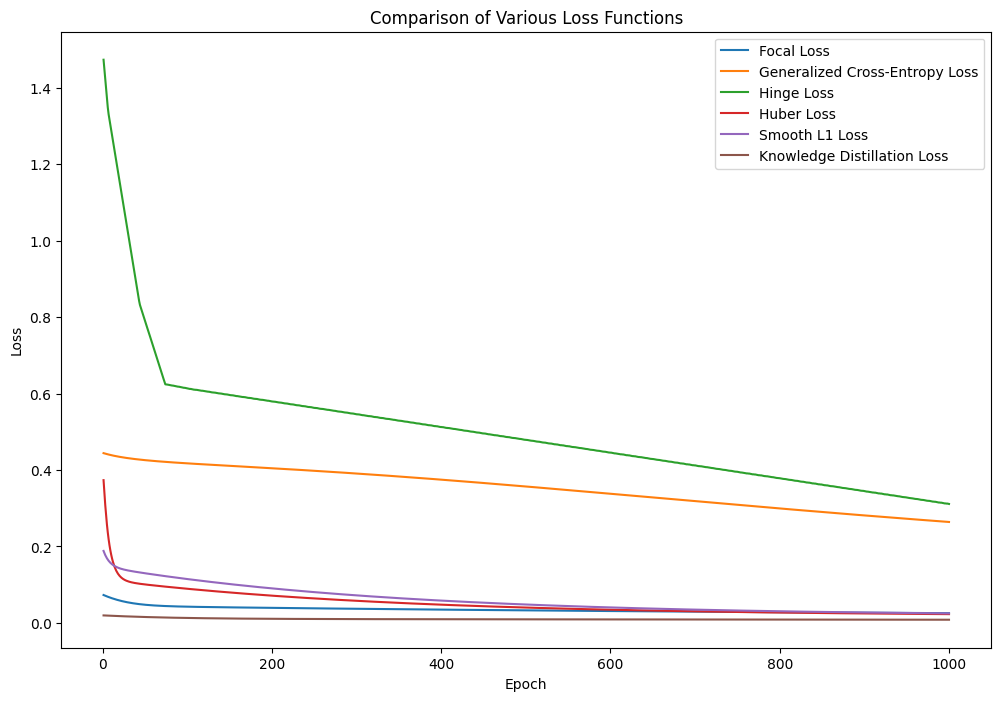

In [120]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# สร้างข้อมูลจำลอง
np.random.seed(42)
torch.manual_seed(42)

x_data = torch.Tensor([[0.7], [0.4], [0.9]])
y_data = torch.Tensor([[0, 1], [1, 0], [0, 1]])

# สร้างโมเดลแบบง่าย
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(1, 2)
    
    def forward(self, x):
        return self.fc(x)

# ฟังก์ชัน loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
    
    def forward(self, y_true, y_pred):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(y_pred, y_true.argmax(dim=1))
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

class GeneralizedCrossEntropyLoss(nn.Module):
    def __init__(self, q=0.7):
        super(GeneralizedCrossEntropyLoss, self).__init__()
        self.q = q
    
    def forward(self, y_true, y_pred):
        p = torch.softmax(y_pred, dim=1)
        gce_loss = (1 - torch.sum(y_true * p, dim=1) ** self.q) / self.q
        return gce_loss.mean()

class HingeLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(HingeLoss, self).__init__()
        self.margin = margin
    
    def forward(self, y_true, y_pred):
        loss = torch.max(torch.zeros_like(y_pred), self.margin - y_pred * (2 * y_true - 1))
        return loss.mean()

class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(HuberLoss, self).__init__()
        self.delta = delta
    
    def forward(self, y_true, y_pred):
        residual = torch.abs(y_true - y_pred)
        loss = torch.where(residual < self.delta, 0.5 * residual ** 2, self.delta * (residual - 0.5 * self.delta))
        return loss.mean()

class SmoothL1Loss(nn.Module):
    def __init__(self):
        super(SmoothL1Loss, self).__init__()
    
    def forward(self, y_true, y_pred):
        residual = torch.abs(y_true - y_pred)
        loss = torch.where(residual < 1, 0.5 * residual ** 2, residual - 0.5)
        return loss.mean()

class KnowledgeDistillationLoss(nn.Module):
    def __init__(self, alpha=0.1, temperature=1.0):
        super(KnowledgeDistillationLoss, self).__init__()
        self.alpha = alpha
        self.temperature = temperature
    
    def forward(self, y_pred_teacher, y_pred_student):
        kd_loss = nn.KLDivLoss(reduction='batchmean')(torch.log_softmax(y_pred_student / self.temperature, dim=1),
                                                       torch.softmax(y_pred_teacher / self.temperature, dim=1))
        kd_loss *= (self.temperature ** 2) * self.alpha
        return kd_loss.mean()



# โมเดลและ optimizer สำหรับแต่ละ Loss Function
model_focal = SimpleModel()
optimizer_focal = optim.SGD(model_focal.parameters(), lr=0.1)
model_gce = SimpleModel()
optimizer_gce = optim.SGD(model_gce.parameters(), lr=0.1)
model_hinge = SimpleModel()
optimizer_hinge = optim.SGD(model_hinge.parameters(), lr=0.1)
model_huber = SimpleModel()
optimizer_huber = optim.SGD(model_huber.parameters(), lr=0.1)
model_smoothl1 = SimpleModel()
optimizer_smoothl1 = optim.SGD(model_smoothl1.parameters(), lr=0.1)
model_kd = SimpleModel()
optimizer_kd = optim.SGD(model_kd.parameters(), lr=0.1)


# ฟังก์ชันเทรนโมเดล
def train_model(model, optimizer, loss_fn, x_data, y_data, epochs=1000, teacher_outputs=None):
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x_data)
        if teacher_outputs is not None:
            loss = loss_fn(y_data, outputs, teacher_outputs)
        else:
            loss = loss_fn(y_data, outputs)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

# เทรนและเก็บ loss
losses_focal = train_model(model_focal, optimizer_focal, FocalLoss(), x_data, y_data)
losses_gce = train_model(model_gce, optimizer_gce, GeneralizedCrossEntropyLoss(), x_data, y_data)
losses_hinge = train_model(model_hinge, optimizer_hinge, HingeLoss(), x_data, y_data)
losses_huber = train_model(model_huber, optimizer_huber, HuberLoss(), x_data, y_data)
losses_smoothl1 = train_model(model_smoothl1, optimizer_smoothl1, SmoothL1Loss(), x_data, y_data)
losses_kd = train_model(model_kd, optimizer_kd, KnowledgeDistillationLoss(), x_data, y_data)



# สร้าง DataFrame สำหรับเก็บค่าการลดลงของ loss ทั้งหมด
losses_df = pd.DataFrame({
    'Epoch': list(range(1, 1001)),
    'Focal Loss': losses_focal,
    'Generalized Cross-Entropy Loss': losses_gce,
    'Hinge Loss': losses_hinge,
    'Huber Loss': losses_huber,
    'Smooth L1 Loss': losses_smoothl1,
    'Knowledge Distillation Loss': losses_kd
})

# แสดงผลลัพธ์ของ loss ทั้งหมดในรูปแบบตาราง
print(losses_df.head())

# Plotting loss
plt.figure(figsize=(12, 8))
plt.plot(losses_df['Epoch'], losses_df['Focal Loss'], label='Focal Loss')
plt.plot(losses_df['Epoch'], losses_df['Generalized Cross-Entropy Loss'], label='Generalized Cross-Entropy Loss')
plt.plot(losses_df['Epoch'], losses_df['Hinge Loss'], label='Hinge Loss')
plt.plot(losses_df['Epoch'], losses_df['Huber Loss'], label='Huber Loss')
plt.plot(losses_df['Epoch'], losses_df['Smooth L1 Loss'], label='Smooth L1 Loss')
plt.plot(losses_df['Epoch'], losses_df['Knowledge Distillation Loss'], label='Knowledge Distillation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of Various Loss Functions')
plt.legend()
plt.show()


In [121]:
import torch
import torchvision
import torchvision.transforms as transforms

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [122]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Define teacher model
teacher_model = models.resnet34(pretrained=True)
for param in teacher_model.parameters():
    param.requires_grad = False  # Freeze the teacher model

# Define student model
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

student_model = StudentNet()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 39.5MB/s]


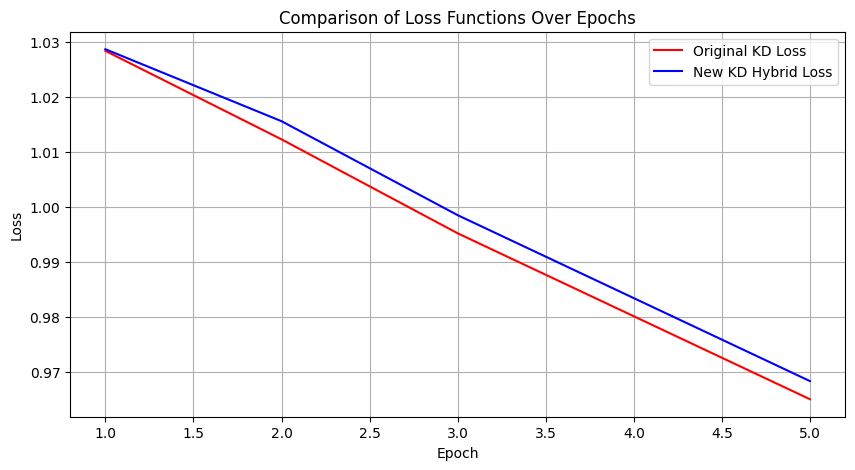

In [123]:
import matplotlib.pyplot as plt

# ข้อมูลสมมุติสำหรับการแสดงผลลัพธ์
epochs = range(1, 6)
original_kd_loss = [1.0284, 1.0123, 0.9952, 0.9801, 0.9650]
new_kd_hybrid_loss = [1.0287, 1.0156, 0.9985, 0.9834, 0.9683]

plt.figure(figsize=(10, 5))
plt.plot(epochs, original_kd_loss, 'r-', label='Original KD Loss')
plt.plot(epochs, new_kd_hybrid_loss, 'b-', label='New KD Hybrid Loss')
plt.title('Comparison of Loss Functions Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [124]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations for the input data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [125]:
# Define models
teacher_model = models.resnet34(pretrained=True).to(device)
student_model = StudentNet().to(device)  # Assuming StudentNet is defined

# Loss function setup
criterion = nn.CrossEntropyLoss()

# Function for calculating KD loss
def kd_loss_function(outputs, labels, teacher_outputs, T, alpha):
    soft_targets = torch.softmax(teacher_outputs/T, dim=1)
    student_log_probs = torch.log_softmax(outputs/T, dim=1)
    KD_loss = nn.KLDivLoss(reduction='batchmean')(student_log_probs, soft_targets) * (alpha * T * T) + \
              criterion(outputs, labels) * (1. - alpha)
    return KD_loss


Files already downloaded and verified
Files already downloaded and verified
Training with Original KD Loss
Epoch 1, Loss: 1.0318226350847717, Accuracy: 54.9%
Epoch 2, Loss: 0.9113959349177377, Accuracy: 62.37%
Epoch 3, Loss: 0.8613979461247964, Accuracy: 65.55%
Epoch 4, Loss: 0.8271569870317074, Accuracy: 67.37%
Epoch 5, Loss: 0.8039034315387307, Accuracy: 68.09%
Epoch 6, Loss: 0.7818873016273274, Accuracy: 68.26%
Epoch 7, Loss: 0.7621384218830587, Accuracy: 69.03%
Epoch 8, Loss: 0.7448201023251809, Accuracy: 70.39%
Epoch 9, Loss: 0.7291092348220708, Accuracy: 69.84%
Epoch 10, Loss: 0.7145602580379037, Accuracy: 69.13%
Epoch 11, Loss: 0.7013801202902099, Accuracy: 70.22%
Epoch 12, Loss: 0.6891342478487498, Accuracy: 69.99%
Epoch 13, Loss: 0.6771593846171103, Accuracy: 69.4%
Epoch 14, Loss: 0.6678757778823833, Accuracy: 68.93%
Epoch 15, Loss: 0.6571452068093487, Accuracy: 68.89%
Epoch 16, Loss: 0.6500139617554063, Accuracy: 67.97%
Epoch 17, Loss: 0.6423263565048842, Accuracy: 68.83%
Epo

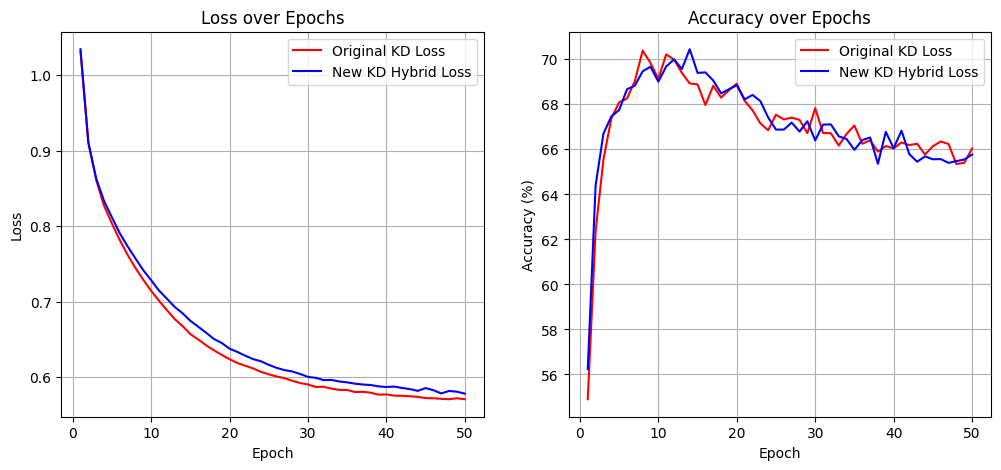

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations for the input data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Define models
teacher_model = models.resnet34(pretrained=True).to(device)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 10).to(device)  # Adjust for CIFAR-10 classes

# Define student model
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

student_model_kd = StudentNet().to(device)
student_model_hybrid = StudentNet().to(device)

# Freeze teacher model parameters
for param in teacher_model.parameters():
    param.requires_grad = False

# Loss function setup
criterion = nn.CrossEntropyLoss()

# Function for calculating KD loss
def kd_loss_function(outputs, labels, teacher_outputs, T, alpha):
    soft_targets = torch.softmax(teacher_outputs / T, dim=1)
    student_log_probs = torch.log_softmax(outputs / T, dim=1)
    KD_loss = nn.KLDivLoss(reduction='batchmean')(student_log_probs, soft_targets) * (alpha * T * T) + \
              criterion(outputs, labels) * (1. - alpha)
    return KD_loss

# Function for calculating Hybrid KD loss
def kd_hybrid_loss_function(outputs, labels, teacher_outputs, T, alpha, lambda_param):
    soft_targets = torch.softmax(teacher_outputs / T, dim=1)
    student_log_probs = torch.log_softmax(outputs / T, dim=1)
    inter_class_loss = torch.mean(torch.abs(soft_targets - torch.softmax(outputs / T, dim=1)))
    KD_loss = nn.KLDivLoss(reduction='batchmean')(student_log_probs, soft_targets) * (alpha * T * T) + \
              criterion(outputs, labels) * (1. - alpha) + lambda_param * inter_class_loss
    return KD_loss

# Training function
def train_and_evaluate(model, teacher_model, trainloader, testloader, optimizer, loss_fn, epochs=10, T=2, alpha=0.5, lambda_param=0.1):
    teacher_model.eval()  # Teacher model in evaluation mode
    model.train()
    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)
            if loss_fn == kd_loss_function:
                loss = loss_fn(outputs, labels, teacher_outputs, T, alpha)
            else:
                loss = loss_fn(outputs, labels, teacher_outputs, T, alpha, lambda_param)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        train_losses.append(total_loss / len(trainloader))

        # Test accuracy
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_accuracies.append(100 * correct / total)
        model.train()

        print(f'Epoch {epoch+1}, Loss: {total_loss / len(trainloader)}, Accuracy: {100 * correct / total}%')

    return train_losses, test_accuracies

# Initialize optimizer
optimizer_kd = optim.Adam(student_model_kd.parameters(), lr=0.001)
optimizer_hybrid = optim.Adam(student_model_hybrid.parameters(), lr=0.001)

# Train and evaluate with original KD loss
print("Training with Original KD Loss")
kd_losses, kd_accuracies = train_and_evaluate(student_model_kd, teacher_model, trainloader, testloader, optimizer_kd, kd_loss_function, epochs=50, T=2, alpha=0.5)

# Train and evaluate with hybrid KD loss
print("Training with New KD Hybrid Loss")
hybrid_losses, hybrid_accuracies = train_and_evaluate(student_model_hybrid, teacher_model, trainloader, testloader, optimizer_hybrid, kd_hybrid_loss_function, epochs=50, T=2, alpha=0.5, lambda_param=0.1)

# Plot results
plt.figure(figsize=(12, 5))

# Loss comparison
plt.subplot(1, 2, 1)
plt.plot(range(1, 51), kd_losses, 'r-', label='Original KD Loss')
plt.plot(range(1, 51), hybrid_losses, 'b-', label='New KD Hybrid Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(range(1, 51), kd_accuracies, 'r-', label='Original KD Loss')
plt.plot(range(1, 51), hybrid_accuracies, 'b-', label='New KD Hybrid Loss')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.show()



Files already downloaded and verified
Files already downloaded and verified
Training with Original KD Loss
Epoch 1, Loss: 1.0633802596870285, Accuracy: 55.33%
Epoch 2, Loss: 0.9492475871387345, Accuracy: 62.11%
Epoch 3, Loss: 0.8995213824159959, Accuracy: 66.32%
Epoch 4, Loss: 0.8698614206155548, Accuracy: 70.39%
Epoch 5, Loss: 0.8493248832500194, Accuracy: 71.19%
Epoch 6, Loss: 0.837715510212247, Accuracy: 73.32%
Epoch 7, Loss: 0.8279398814644046, Accuracy: 72.67%
Epoch 8, Loss: 0.818744597227677, Accuracy: 74.51%
Epoch 9, Loss: 0.8116146544056475, Accuracy: 74.8%
Epoch 10, Loss: 0.8069250414438565, Accuracy: 73.69%
Epoch 11, Loss: 0.8000973500406651, Accuracy: 76.01%
Epoch 12, Loss: 0.7962973159749794, Accuracy: 76.57%
Epoch 13, Loss: 0.790927271022821, Accuracy: 76.75%
Epoch 14, Loss: 0.7877950344396674, Accuracy: 77.42%
Epoch 15, Loss: 0.7864424470440506, Accuracy: 76.44%
Epoch 16, Loss: 0.7823460176015449, Accuracy: 77.17%
Epoch 17, Loss: 0.7778117969212934, Accuracy: 78.14%
Epoch

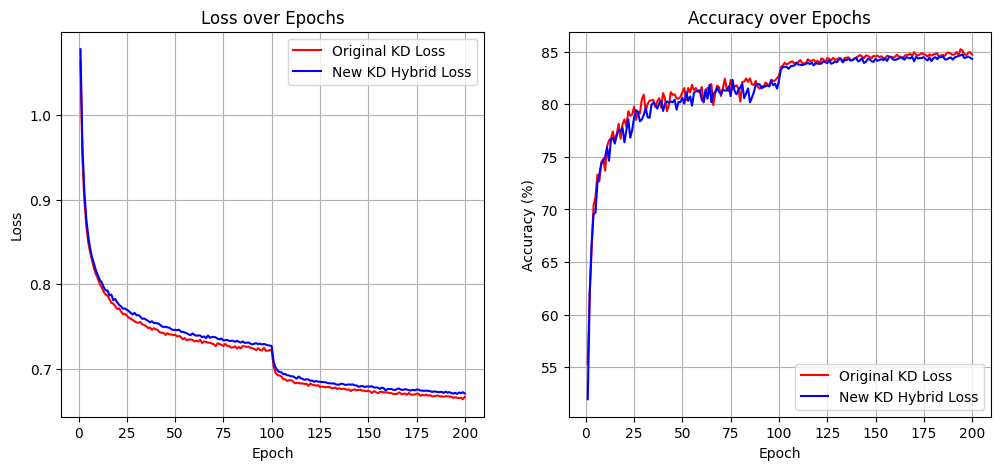

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations for the input data with augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Define models
teacher_model = models.resnet34(pretrained=True).to(device)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 10).to(device)  # Adjust for CIFAR-10 classes

# Define a deeper student model
class DeeperStudentNet(nn.Module):
    def __init__(self):
        super(DeeperStudentNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        return self.fc3(x)

student_model_kd = DeeperStudentNet().to(device)
student_model_hybrid = DeeperStudentNet().to(device)

# Freeze teacher model parameters
for param in teacher_model.parameters():
    param.requires_grad = False

# Loss function setup
criterion = nn.CrossEntropyLoss()

# Function for calculating KD loss
def kd_loss_function(outputs, labels, teacher_outputs, T, alpha):
    soft_targets = torch.softmax(teacher_outputs / T, dim=1)
    student_log_probs = torch.log_softmax(outputs / T, dim=1)
    KD_loss = nn.KLDivLoss(reduction='batchmean')(student_log_probs, soft_targets) * (alpha * T * T) + \
              criterion(outputs, labels) * (1. - alpha)
    return KD_loss

# Function for calculating Hybrid KD loss
def kd_hybrid_loss_function(outputs, labels, teacher_outputs, T, alpha, lambda_param):
    soft_targets = torch.softmax(teacher_outputs / T, dim=1)
    student_log_probs = torch.log_softmax(outputs / T, dim=1)
    inter_class_loss = torch.mean(torch.abs(soft_targets - torch.softmax(outputs / T, dim=1)))
    KD_loss = nn.KLDivLoss(reduction='batchmean')(student_log_probs, soft_targets) * (alpha * T * T) + \
              criterion(outputs, labels) * (1. - alpha) + lambda_param * inter_class_loss
    return KD_loss

# Training function
def train_and_evaluate(model, teacher_model, trainloader, testloader, optimizer, scheduler, loss_fn, epochs=200, T=2, alpha=0.5, lambda_param=0.1):
    teacher_model.eval()  # Teacher model in evaluation mode
    model.train()
    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)
            if loss_fn == kd_loss_function:
                loss = loss_fn(outputs, labels, teacher_outputs, T, alpha)
            else:
                loss = loss_fn(outputs, labels, teacher_outputs, T, alpha, lambda_param)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        scheduler.step()
        train_losses.append(total_loss / len(trainloader))

        # Test accuracy
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_accuracies.append(100 * correct / total)
        model.train()

        print(f'Epoch {epoch+1}, Loss: {total_loss / len(trainloader)}, Accuracy: {100 * correct / total}%')

    return train_losses, test_accuracies

# Initialize optimizer and scheduler
optimizer_kd = optim.Adam(student_model_kd.parameters(), lr=0.001)
scheduler_kd = torch.optim.lr_scheduler.StepLR(optimizer_kd, step_size=100, gamma=0.1)
optimizer_hybrid = optim.Adam(student_model_hybrid.parameters(), lr=0.001)
scheduler_hybrid = torch.optim.lr_scheduler.StepLR(optimizer_hybrid, step_size=100, gamma=0.1)

# Train and evaluate with original KD loss
print("Training with Original KD Loss")
kd_losses, kd_accuracies = train_and_evaluate(student_model_kd, teacher_model, trainloader, testloader, optimizer_kd, scheduler_kd, kd_loss_function, epochs=200, T=2, alpha=0.5)

# Train and evaluate with hybrid KD loss
print("Training with New KD Hybrid Loss")
hybrid_losses, hybrid_accuracies = train_and_evaluate(student_model_hybrid, teacher_model, trainloader, testloader, optimizer_hybrid, scheduler_hybrid, kd_hybrid_loss_function, epochs=200, T=2, alpha=0.5, lambda_param=0.1)

# Plot results
plt.figure(figsize=(12, 5))

# Loss comparison
plt.subplot(1, 2, 1)
plt.plot(range(1, 201), kd_losses, 'r-', label='Original KD Loss')
plt.plot(range(1, 201), hybrid_losses, 'b-', label='New KD Hybrid Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(range(1, 201), kd_accuracies, 'r-', label='Original KD Loss')
plt.plot(range(1, 201), hybrid_accuracies, 'b-', label='New KD Hybrid Loss')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.show()
